In [9]:
import numpy as np
import pandas as pd
import csv
from scipy.spatial import distance_matrix

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns

In [10]:
%load_ext autoreload
%autoreload 2
from main.utils.loaders import FaceDataSet
from main.models.baseline_resnet import set_basemodel
from main.fairness.quantile_transport import Calibrator

from main.viz.image_grids import imshow

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
device_ = torch.device('mps')

## Run predictions on small dataset

In [12]:
# Load up data
data_labs = pd.read_csv('data/prepared/faces/direct_faces.csv')

In [13]:
#  Load model and prepare
weights_resnet = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights_resnet)
preprocessor_ = weights_resnet.transforms()

valid_dataset = FaceDataSet(data_labs, sens_idx=21,transform=preprocessor_)
validation_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=True)

In [15]:
# Load up keys
model = set_basemodel(device=device_)
model.load_state_dict(torch.load('data/models/updated_weights_simple.torch'))

<All keys matched successfully>

In [16]:
for i, (inputs, labels, sens_labs) in enumerate(validation_dataloader):
    inputs, labels = Variable(inputs.to(device_)), Variable(labels.to(device_)) 
    model = model.eval()

    with torch.no_grad():
        preds_ = model(inputs)

    preds_np = torch.sigmoid(preds_).squeeze().cpu().detach().numpy()
    labs_np = labels.cpu().detach().numpy()
    sens_labs = sens_labs.cpu().detach().numpy()

    if i == 0:
        all_preds = np.empty_like(preds_np)
        all_labs = np.empty_like(preds_np)
        all_sens = np.empty_like(preds_np)
        all_inputs = torch.empty_like(inputs)

    all_preds = np.concatenate([all_preds, preds_np])
    all_labs = np.concatenate([all_labs, labs_np])
    all_sens = np.concatenate([all_sens, sens_labs])
    all_inputs = torch.cat([all_inputs, inputs], axis=0)

all_preds = all_preds[128:]
all_labs = all_labs[128:]
all_sens = all_sens[128:]
all_inputs = all_inputs[128:,:,:,:]

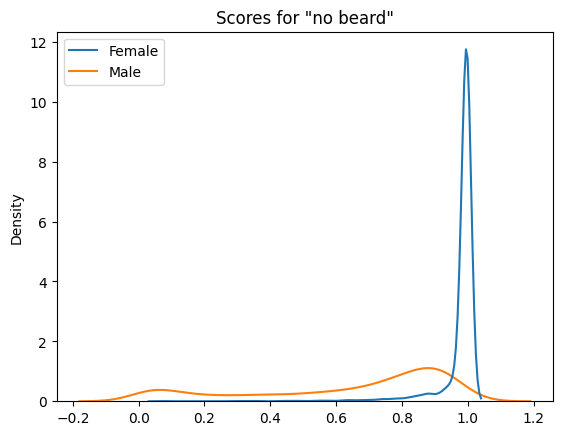

In [17]:
sns.kdeplot(x=all_preds, hue=np.where(all_sens > 0.5, 'Male', 'Female'))
plt.title('Scores for "no beard"');

In [18]:
arguments_sorted = np.argsort(all_preds)

## Visualize

In [19]:
lowest_scores = all_inputs[arguments_sorted[:200], :, :, :].cpu()
highest_scores = all_inputs[arguments_sorted[-200:], :, :, :].cpu()

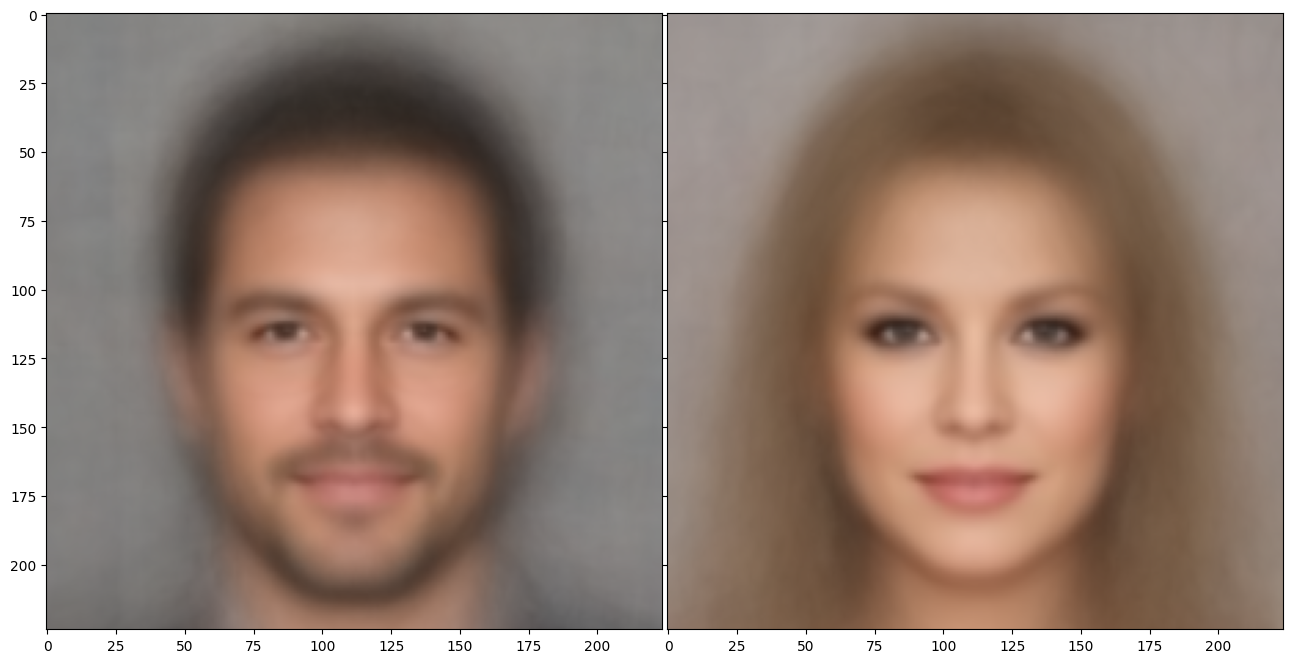

In [55]:
mean_low = torch.mean(lowest_scores, 0)
mean_high = torch.mean(highest_scores, 0)

fig = plt.figure(1, figsize=(16, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.05)


imshow(grid[0], mean_low)
imshow(grid[1], mean_high)


## Calibrate

In [58]:
calibrator_ = Calibrator()
calibrator_.fit(all_preds, all_sens)
scores_corrected = calibrator_.transform(all_preds, all_sens)

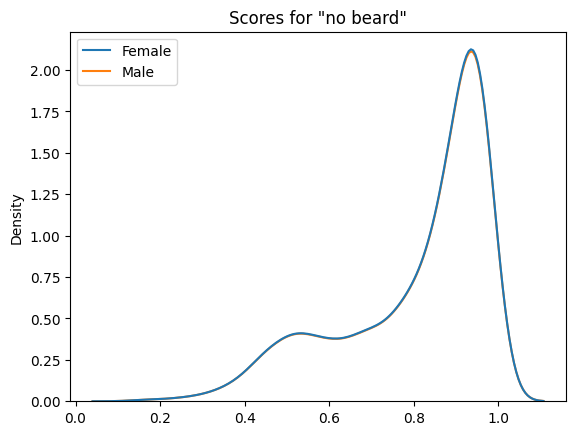

In [63]:
# Viz
sns.kdeplot(x=scores_corrected, hue=np.where(all_sens > 0.5, 'Male', 'Female'))
plt.title('Scores for "no beard"');

In [60]:
scores_corrected_low = scores_corrected[arguments_sorted[:200]]
scores_corrected_high = scores_corrected[arguments_sorted[-200:]]

In [82]:
vec_ = np.empty(shape=(5000))
for k in range(scores_corrected_low.shape[0]):
    vec_tmp = np.abs(scores_corrected_low[k] - all_preds)
    vec_ = np.vstack([vec_, vec_tmp])

In [89]:
corrected_indices = vec_[1:,:].argmin(axis=1)

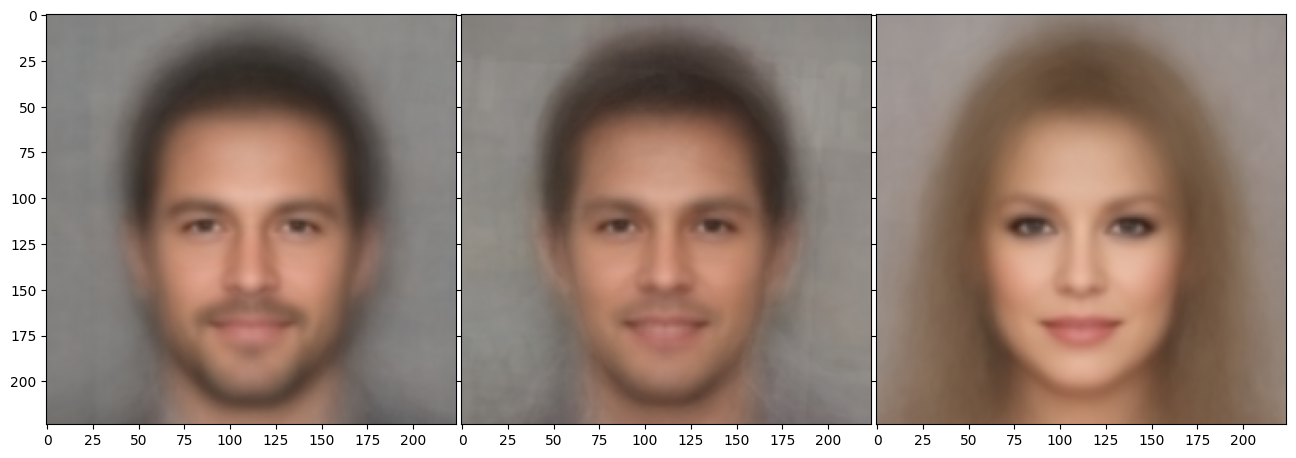

In [91]:
corrected_score = all_inputs[corrected_indices, :, :, :].cpu()

mean_low = torch.mean(lowest_scores, 0)
mean_high = torch.mean(highest_scores, 0)
mean_corrected = torch.mean(corrected_score, 0)

fig = plt.figure(1, figsize=(16, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.05)

imshow(grid[0], mean_low)
imshow(grid[1], mean_corrected)
imshow(grid[2], mean_high)

In [ ]:
corrected_score = all_inputs[corrected_indices, :, :, :].cpu()

mean_low = torch.mean(lowest_scores, 0)
mean_high = torch.mean(highest_scores, 0)
mean_corrected = torch.mean(corrected_score, 0)

fig = plt.figure(1, figsize=(16, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.05)

imshow(grid[0], mean_low)
imshow(grid[1], mean_corrected)
imshow(grid[2], mean_high)

## Barycenter on quantiles of dist

Use below quantiles from both scores distr and repeat

In [112]:
def closest(lst, K):     
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [113]:
closest(list(all_preds), 0.08555123358964922)

0.08525067

In [115]:
np.argwhere(all_preds == 0.08525067)

array([[408]])

In [118]:
want_idx = np.array([3448, 408])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


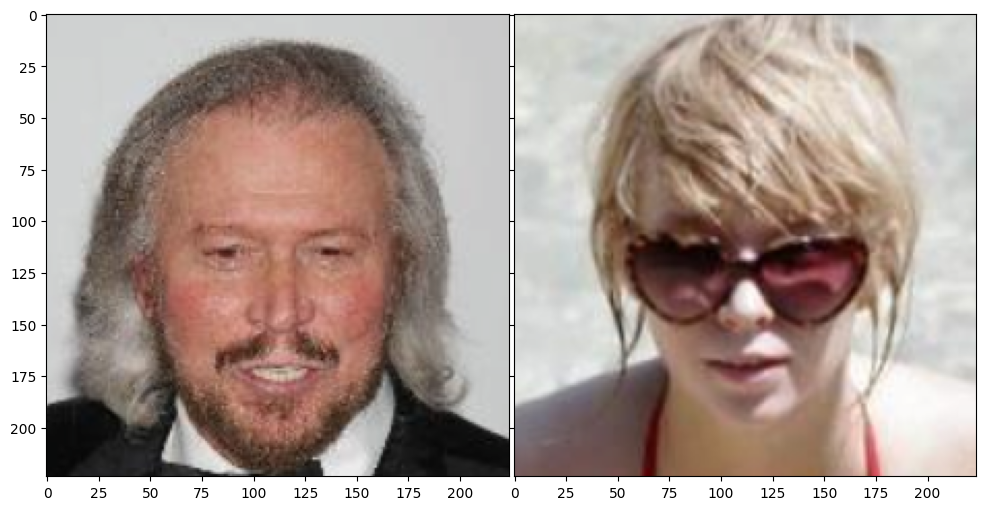

In [121]:
low_ = all_inputs[408, :, :, :].cpu()
high_ = all_inputs[4390, :, :, :].cpu()

fig = plt.figure(1, figsize=(12, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.05)

imshow(grid[0], low_)
imshow(grid[1], high_)

## Create interpolation between two individuals

- Use kth quantile for man, use obs around kth quantile of women (and average)
- Interpolate regions (with different weights)

In [156]:
below_10 = np.argwhere(all_preds < 0.10)
above_6 = np.argwhere(all_preds > 0.06)

above_93 = np.argwhere(all_preds > 0.93)
below_98 = np.argwhere(all_preds < 0.98)

is_male = np.argwhere(all_sens > 0.5)
is_female = np.argwhere(all_sens < 0.5)

set_1 = set(below_10.squeeze()).intersection(set(above_6.squeeze()))
set_male = set_1.intersection(set(is_male.squeeze()))

set_2 = set(below_98.squeeze()).intersection(set(above_93.squeeze()))
set_female = set_2.intersection(set(is_female.squeeze()))

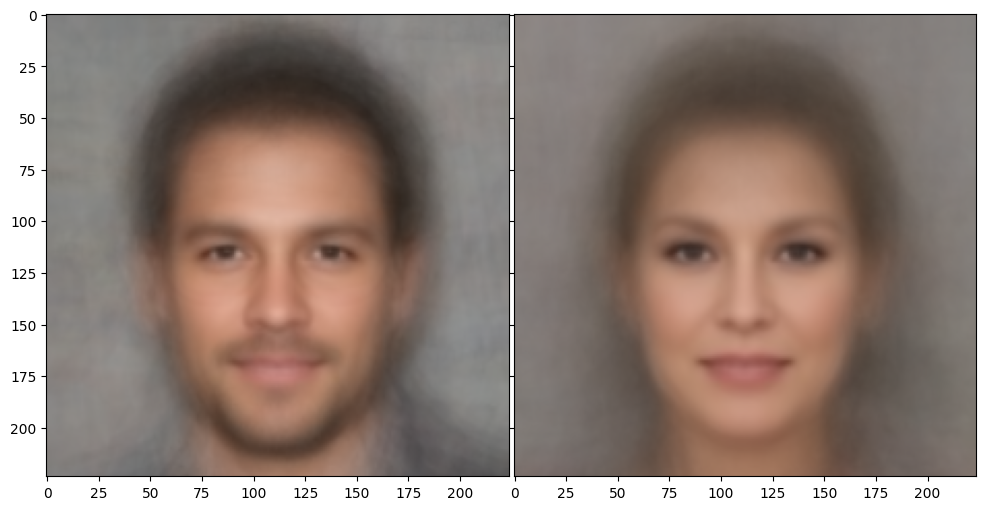

In [157]:
male_quant = all_inputs[list(set_male), :, :, :].cpu()
female_quant = all_inputs[list(set_female), :, :, :].cpu()

mean_male = torch.mean(male_quant, 0)
mean_female = torch.mean(female_quant, 0)

fig = plt.figure(1, figsize=(12, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.05)

imshow(grid[0], mean_male)
imshow(grid[1], mean_female)

Preserves "Male attributes" such as rougher facial features and darker hair

**Notes:**

Show difference across features and scores within Quartiles

In [159]:
below_corr = np.argwhere(all_preds < 0.54)
above_corr = np.argwhere(all_preds > 0.50)
set_3 = set(below_corr.squeeze()).intersection(set(above_corr.squeeze()))

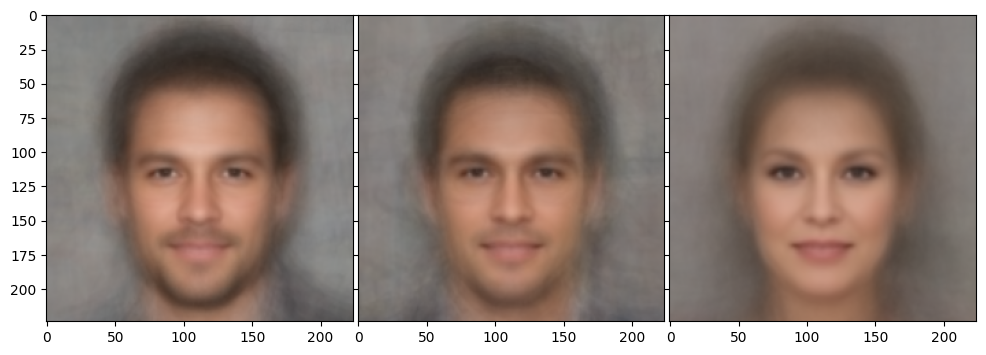

In [160]:
fair_quant = all_inputs[list(set_3), :, :, :].cpu()

mean_fair = torch.mean(fair_quant, 0)

fig = plt.figure(1, figsize=(12, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.05)

imshow(grid[0], mean_male)
imshow(grid[1], mean_fair)
imshow(grid[2], mean_female)

## Create interpolation in dim 2:4

**Notes:**

Use deblur from pixel (to strengthen feature transformation)

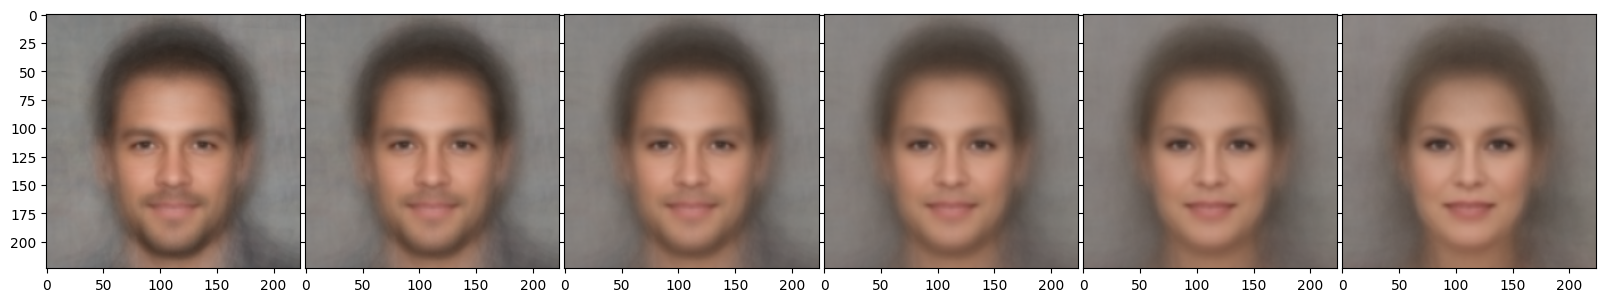

In [164]:
fig = plt.figure(1, figsize=(20, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 6), axes_pad=0.05)

mean_list_ = []
for lambda_ in np.linspace(0,1,6):
    mean_list_.append((1-lambda_)*mean_male + (lambda_)*mean_female)

for id, gr in enumerate(grid):
    imshow(grid[id], mean_list_[id])